# Importing packages 

In [14]:
# Data wrangling 
import pandas as pd 

# Deep learning 
import tensorflow as tf
import keras 

# Array math 
import numpy as np

# One hot encoding
from sklearn.preprocessing import OneHotEncoder

# Mean scaler 
from sklearn.preprocessing import MinMaxScaler

# Loading the memory profile extension
from memory_profiler import profile
import sys 

# Ploting 
import matplotlib.pyplot as plt

# Iteration tracking
from tqdm import tqdm

# Metrics 
from sklearn.metrics import mean_squared_error

# Importing the feature engineering functions 
from utils import distance_calculation, create_date_vars, create_dummy

# Reading the data 

In [24]:
d = pd.read_csv('data/train.csv', chunksize=512)

# Defining the number of chunks to read 
n_chunks = 1000

df = pd.DataFrame({})
for i, chunk in tqdm(enumerate(d)):
    if i == n_chunks:
        break
    df = pd.concat([df, chunk], axis=0)

# Removing the negative fare_amount
df = df[df['fare_amount'] > 0].copy()

# Dropping missing rows
df.dropna(inplace=True)

# reseting the index
df.reset_index(inplace=True, drop=True)

print(f"Shape of the data: {df.shape}")
print(df.describe().round(2))

1000it [00:11, 90.23it/s]


Shape of the data: (511960, 8)
       fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count    511960.00         511960.00        511960.00          511960.00   
mean         11.36            -72.52            39.92             -72.52   
std           9.91             11.82             8.07              11.76   
min           0.01          -2986.24         -3116.29           -3383.30   
25%           6.00            -73.99            40.73             -73.99   
50%           8.50            -73.98            40.75             -73.98   
75%          12.50            -73.97            40.77             -73.96   
max         500.00           2140.60          1703.09              40.85   

       dropoff_latitude  passenger_count  
count         511960.00        511960.00  
mean              39.92             1.68  
std                7.36             1.31  
min            -2559.75             0.00  
25%               40.73             1.00  
50%               40.75   

In [25]:
# Getting the size of the object in memory
print(f"The object takes: {sys.getsizeof(df) / 10**6} MB in memory")

The object takes: 108.882466 MB in memory


# Feature engineering 

## Date variables 

In [26]:
df = create_date_vars(df)

## Dummy variables

The features that will be one-hot encoded: 

* pickup_dayofweek

In [27]:
# Defining the dummy var list 
dummy_features = [
    'pickup_dayofweek'
]

# Creating the dummy vars
df, new_features = create_dummy(df, dummy_features)

In [28]:
df.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'pickup_hour', 'pickup_dayofyear', 'pickup_hour_sin',
       'pickup_hour_cos', 'pickup_dayofyear_sin', 'pickup_dayofyear_cos',
       'pickup_dayofweek_1', 'pickup_dayofweek_2', 'pickup_dayofweek_3',
       'pickup_dayofweek_4', 'pickup_dayofweek_5', 'pickup_dayofweek_6'],
      dtype='object')

## Distance of travel 

In [20]:
df = distance_calculation(df)

# EDA

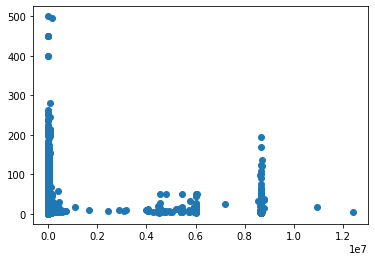

In [22]:
plt.scatter(y=df['fare_amount'], x=df['distance'])

<AxesSubplot:xlabel='passenger_count'>

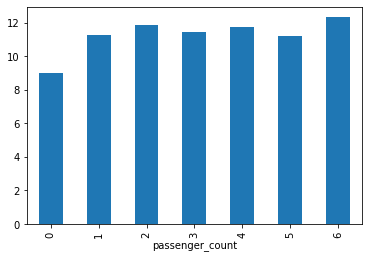

In [23]:
df.groupby('passenger_count')['fare_amount'].mean().plot(kind='bar')

<AxesSubplot:xlabel='pickup_dayofweek_1,pickup_dayofweek_2,pickup_dayofweek_3,pickup_dayofweek_4,pickup_dayofweek_5,pickup_dayofweek_6'>

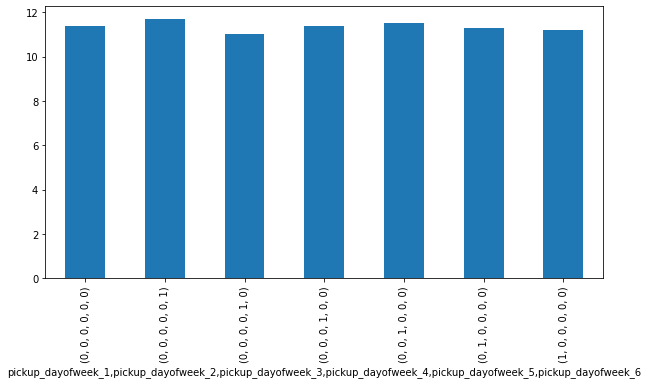

In [31]:
df.groupby(['pickup_dayofweek_1', 'pickup_dayofweek_2', 'pickup_dayofweek_3',
       'pickup_dayofweek_4', 'pickup_dayofweek_5', 'pickup_dayofweek_6'])['fare_amount'].mean().plot(kind='bar', figsize=(10, 5))

<AxesSubplot:xlabel='pickup_hour'>

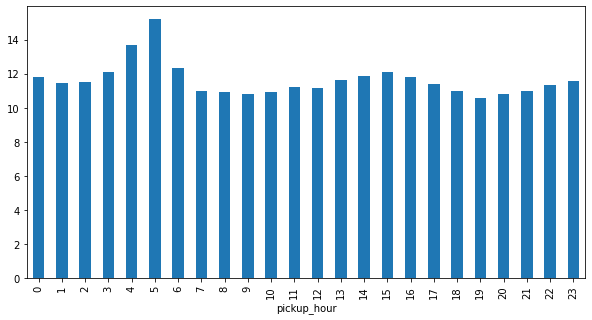

In [34]:
df.groupby('pickup_hour')['fare_amount'].mean().plot(kind='bar', figsize=(10, 5))

## Final feature list and the ft engineering pipeline 


In [39]:
# Defining the final feature list 
numeric_features = [
    'distance',
    'passenger_count', 
    'pickup_hour_sin',
    'pickup_hour_cos',
    'pickup_dayofyear_sin',
    'pickup_dayofyear_cos',
]

# Defining the target variable
target = 'fare_amount'

# Defining the ft engineering pipeline 
def ft_engineering_pipeline(
    df, 
    numeric_features, 
    dummy_features,
    target):
    """
    Applies the feature engineering pipeline to the data
    """
    # Creating the date variables
    df = create_date_vars(df)

    # Creating the dummy variables
    df, new_features = create_dummy(df, dummy_features)

    # Appending the distance
    df = distance_calculation(df) 

    # Appending the new features to the numeric features
    final_features = numeric_features + new_features

    # Creating the x matrix 
    x = df[final_features].values

    # Creating the y vector
    y = df[target].values

    # Mean max scaling the y matrix 
    y = y.reshape(-1, 1)
    scaler = MinMaxScaler()
    y = scaler.fit_transform(y)

    # Returning the x and y matrices
    return x, y, final_features

# Creating the input for model 

In [40]:
x, y, features = ft_engineering_pipeline(df, numeric_features, dummy_features, target)

In [41]:
print(f"Shape of x: {x.shape} | Shape of y: {y.shape}")
print(features)

Shape of x: (511960, 18) | Shape of y: (511960, 1)
['distance', 'passenger_count', 'pickup_hour_sin', 'pickup_hour_cos', 'pickup_dayofyear_sin', 'pickup_dayofyear_cos', 'pickup_dayofweek_1', 'pickup_dayofweek_2', 'pickup_dayofweek_3', 'pickup_dayofweek_4', 'pickup_dayofweek_5', 'pickup_dayofweek_6']


# Deep learning 

In [42]:
# Defining the batch size and number of epochs 
batch_size = 512
epochs = 10

In [ ]:
# Defining the model function 
def train(x, y, epochs: int = 10, batch_size: int = 128): 
    # Defining a simple feed forward network 
    model = keras.Sequential([
        keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(x.shape[1],)),
        keras.layers.Dense(128, activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])

    # Compiling the model
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mean_squared_error']
    )

    # Fitting the model
    history = model.fit(x, y, epochs=epochs, batch_size=batch_size)

    # Returning the model
    return model, history

In [ ]:
# Training the model with RAM usage 
model, history = train(x, y, epochs=epochs, batch_size=batch_size)

In [ ]:
plt.plot(history.history['mean_squared_error'])